# Real_estate

**Исследование объявлений о продаже квартир**

Используя архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет, была определена рыночная стоимость объектов недвижимости в зависимости и типичные параметры квартир.
По каждому объекту доступны два вида данных: данные, которые указал продавец в объявлении, и картографические данные (расстояние до центра, аэропорта, ближайшего парка и водоёма).

**План**
- изучим информацию о датасете
- определим пропущенных значения и артефакты - обработаем их
- определим конкретные типы переменных
- добавим информации о цене кв.метра, дни недели, месяца и года публикации объявления, сделаем разметку этажей, соотношение жилой площади к общей и площади кухни к общей
- посмотрим как признаки объекта недвижимости влияют на его цену в следующих разрезах:
    - в целом по базе
    - в ТОП-10 городов по количеству объявлений
    - в Санкт-Петербурге
    - в центре Санкт-Петербурга



### Шаг 1. Изучим общую информацию. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [1]:
### Инсайты

1. В столбце Is_apartment есть False и NaN и тип этого столбца лучше поменять на bool
2. Количество аэропортов, прудов, парков, этажей и комнат - необходимо перевести в int
3. В столбце first_day_exposition нужно поработать с форматом даты
4. Дубликатов нет
5. Много пропущенных значений


**Возможные причины возникновения пропусков**
- человеческий фактор - не заполнены 0, там где отсутствуют признаки, например, отсутствие балкона или парка поблизости
- пропуски в значении высота потолков обсуловлен тем, что это неочевидный фактор при заполнении анкеты, высота потолков скорее всего типовая, а в анкете отразили только "отклонения от нормы"

### Шаг 2. Предобработка данных

#### Обрабатываем пропущенные значения

In [9]:
# Список столбцов, в которых пропуски можно заменить средним значением

columns_list_mean = ['floors_total', 'kitchen_area', 'cityCenters_nearest',
                     'parks_nearest','ponds_nearest','airports_nearest']
for column_type in columns_list_mean:
    df.loc[df[column_type].isna(), column_type] = df[column_type].mean()

In [10]:
# Отработаем пропуски в столбце ceiling_height. Предположим, что высота потолков типовая в домах одинаковой этажности
# Заменим пропуски средним значением в зависимости от этажности

floors_total_types_list = df.floors_total.sort_values().unique()
for floors_total in floors_total_types_list:
    mean = df.loc[(~df['ceiling_height'].isna()) & (df['floors_total'] == floors_total),'ceiling_height'].mean()
    df.loc[
        df['floors_total']==floors_total,'ceiling_height'] = df.loc[
        df['floors_total']==floors_total,'ceiling_height'].fillna(value = mean)
df.loc[df['ceiling_height'].isna()] # есть только одна запись 33 этажного дома и это артефакт

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11575,9,9900000.0,101.0,2016-04-28T00:00:00,3,NaN,33.0,53.0,32,False,...,21.0,0.0,Санкт-Петербург,18732.0,20444.0,0.0,490.804555,3.0,80.0,53.0


In [11]:
# удалим строку с некорректными данными по этажности дома

df = df.dropna(subset = ['ceiling_height'])
df['ceiling_height'].isna().sum()

0

In [12]:
# Проверим артефакты в столбце floors_total

df['floors_total'].describe()

count    23698.000000
mean        10.672882
std          6.583733
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [13]:
# 60 этажный и 52 этажный дома навряд ли возможны в Питере, возможно 60 это опечатка от 6, а 52 - от 5  
# сделаем замену

df.loc[df['floors_total'] == 60, 'floors_total'] = 6
df.loc[df['floors_total'] == 52, 'floors_total'] = 5

In [14]:
# Список солбцов, в которых пропуски можно заменить на 0

columns_list_null = ['balcony', 'ponds_around3000','parks_around3000']
for column_type in columns_list_null:
    df.loc[df[column_type].isna(), column_type] = df.loc[df[column_type].isna(), column_type].fillna(value=0)

**Пропуски в выше перечисленных столбцах обусловлены некорректным заполнением анкеты - человеческим фактором. Скорее всего просто не заполнили информацию о том, чего нет, например, балкона.**

In [15]:
# Пропуски в столбце соответствуют False. Значения NaN не отражаются при использовании метода info()
# заменим их

df.loc[df['is_apartment'].isna(),'is_apartment'] = df.loc[df['is_apartment'].isna(),'is_apartment'].fillna(value = False)
df['is_apartment'].value_counts()

False    23648
True        50
Name: is_apartment, dtype: int64

In [16]:
# Пропуски в столбце living_area некорректно заменить средним значением, так как жилая площадь в 15-комнатной
# квартире отличаетcя от 1-комнатной

# Заменим среднее значени жилой площади по количеству комнат

room_types_list = df.rooms.sort_values().unique()
for room_type in room_types_list:
    mean = df.loc[(~df['living_area'].isna()) & (df['rooms'] == room_type),'living_area'].mean()
    df.loc[
        df['rooms']==room_type,'living_area'] = df.loc[
        df['rooms']==room_type,'living_area'].fillna(value = mean)
df['living_area'].isna().sum()

0

In [18]:
# Пропуски в названии населенного пункта скорее всего не заполнены, т.к. это база данных недвижимости Питера
# Заменим пропуски на значение "Санкт-Петербург"

df.loc[df['locality_name'].isna(),'locality_name'] = df.loc[
df['locality_name'].isna(),'locality_name'].fillna(value = 'Санкт-Петербург')
df['locality_name'].isna().sum()

0

In [19]:
# Обработаем столбец first_day_exposition - уберем время публикации

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%d')

**Пропуска в столбце days_exposition - означают, что объявление еще не снято с публикации. Их заменять не нужно**

**Исправим некорректный тип данных**

In [20]:
# Заменим столбец is_apartment на тип bool

df['is_apartment'] = df['is_apartment'].astype(bool)

In [21]:
# Заменим столбцы с количеством и ценой на тип int

columns_list = ['last_price', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'last_price']
for column in columns_list:
    df[column] = df[column].astype(int)

In [22]:
# Проверяем, что нужные пропуски заполнены и все данные соответствуют свое
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23698 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23698 non-null  int64         
 1   last_price            23698 non-null  int64         
 2   total_area            23698 non-null  float64       
 3   first_day_exposition  23698 non-null  datetime64[ns]
 4   rooms                 23698 non-null  int64         
 5   ceiling_height        23698 non-null  float64       
 6   floors_total          23698 non-null  int64         
 7   living_area           23698 non-null  float64       
 8   floor                 23698 non-null  int64         
 9   is_apartment          23698 non-null  bool          
 10  studio                23698 non-null  bool          
 11  open_plan             23698 non-null  bool          
 12  kitchen_area          23698 non-null  float64       
 13  balcony         

### Вывод

1. Пропуски в количественных признаках заменены на среднее, кроме living_area - заменено на среднее по количеству комнат
    1. Пропущенные значения, которые соответствуют отсутствиям признака, заменены соответственно на нули
    2. Предположила, что пропуски в наименовании населенного пункта - это отсутствие указание на Питер, так как база недвижимости Санкт-Петербурга
    3. Отработала артефакты в количестве этажности, скорее всего это опечатка - заменены на первую цифру числа
2. Пропуски в столбце количество дней публикации не заполнены, так как они означают, что объявление не снято с публикации
3. Максимальное количество комнат соответствует действительности, так как 19 комнат может быть в частных домах в пригороде

### Шаг 3. Посчитайте и добавьте в таблицу

**Посчитаем цену квадратного метра**

In [23]:
df['cost'] = df['last_price']/df['total_area']
df['cost'].mean() #  Посмотрим среднюю цену квадратного метра

99421.71554958545

#### Средняя цена по всей базе недвижимости - 99 421 рубль. Скорее всего в центре цена квадратного метра будет выше.

**Добавим дни недели, месяц и год публикации объявления**

In [24]:
df['week_day'] = df['first_day_exposition'].dt.weekday #  номер дня недели

# Добавим название дня недели
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
df['day_of_week'] = df['week_day'].apply(lambda x: days[x]) #  добавляем столбец с наименование дней

In [25]:
df['month'] = df['first_day_exposition'].dt.month #  месяц
df['year'] = df['first_day_exposition'].dt.year #  год

**Разметка этажей**

In [26]:
 def first_last_floor(row): #  функция, которая определяет последний и первый этажи
    if row['floor'] == row['floors_total']:
        return 'последний'
    if row['floor'] == 1:
        return 'первый'
    return 'другой'
df['first_last_floor'] = df.apply(first_last_floor, axis=1)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost,week_day,day_of_week,month,year,first_last_floor
0,20,13000000,108.0,2019-03-07,3,2.700000,16,51.000000,8,False,...,482.000000,2,755.0000,NaN,120370.370370,3,Thurs,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.782385,11,18.600000,1,False,...,490.804555,0,517.9809,81.0,82920.792079,1,Tues,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.793191,5,34.300000,4,False,...,90.000000,2,574.0000,558.0,92785.714286,3,Thurs,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.731545,14,47.386895,9,False,...,84.000000,3,234.0000,424.0,408176.100629,4,Fri,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.030000,14,32.000000,13,False,...,112.000000,1,48.0000,121.0,100000.000000,1,Tues,6,2018,другой


In [27]:
# создадим функцию для расчета соотношение жилой и общей площади, а также отношение площади кухни к общей

def rate (row):
    living_rate = row['living_area'] / row['total_area']
    kitchen_rate = row['kitchen_area'] / row['total_area']
    return pd.Series([living_rate, kitchen_rate], index=['living_rate', 'kitchen_rate']) # возращаем Series

df = df.join(df.apply(rate, axis=1)) # создаем новый Data_Frame и объединяем с нашим DataFrame
df.head() 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,cost,week_day,day_of_week,month,year,first_last_floor,living_rate,kitchen_rate
0,20,13000000,108.0,2019-03-07,3,2.700000,16,51.000000,8,False,...,755.0000,NaN,120370.370370,3,Thurs,3,2019,другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.782385,11,18.600000,1,False,...,517.9809,81.0,82920.792079,1,Tues,12,2018,первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.793191,5,34.300000,4,False,...,574.0000,558.0,92785.714286,3,Thurs,8,2015,другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,2.731545,14,47.386895,9,False,...,234.0000,424.0,408176.100629,4,Fri,7,2015,другой,0.298031,0.066477
4,2,10000000,100.0,2018-06-19,2,3.030000,14,32.000000,13,False,...,48.0000,121.0,100000.000000,1,Tues,6,2018,другой,0.320000,0.410000


#### Информация добавлена в DataFrame, приступаем к анализу

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Изучаем параметры: площадь, цена, число комнат, высота потолков. 

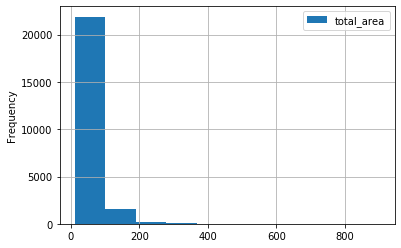

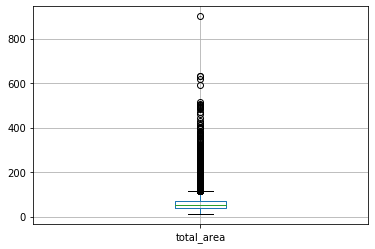

In [28]:
# Гистограмма и диаграмма размаха общей площади

df['total_area'].describe()
df.plot(y='total_area', kind = 'hist', grid = True)
plt.show()
df.boxplot('total_area')
plt.show()

Объектов недвижимости с площадью более чем 200 метров - мало
Также есть значения менее 20 метров - это выглядит неправдоподобно
Сделаем срез, чтобы посмотреть сколько объектов площадью более 200 кв.метров и менее 20

In [29]:
too_small_total_area = df.query('total_area < 20')
too_small_total_area['total_area'].describe()

# 27 строк с площадью менее 20 метров - эти данные можно опустить

count    27.000000
mean     16.606667
std       2.277239
min      12.000000
25%      15.000000
50%      17.600000
75%      18.200000
max      19.500000
Name: total_area, dtype: float64

In [30]:
too_big_total_area = df.query('total_area > 200')
too_big_total_area.describe()
# Объектов с площадью более 200 метров - 227 строк. Такая жил.площадь может быть, но такие значения малозначительны

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost,week_day,month,year,living_rate,kitchen_rate
count,227.000000,2.270000e+02,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,...,227.000000,227.000000,227.000000,175.000000,2.270000e+02,227.000000,227.000000,227.000000,227.000000,227.000000
mean,12.361233,5.981826e+07,284.609648,5.788546,3.239873,6.471366,156.766276,4.911894,27.687993,0.387665,...,448.861497,1.308370,436.395160,316.840000,2.010927e+05,2.700441,6.370044,2016.986784,0.567325,0.101024
std,6.604631,7.422253e+07,95.844475,2.226003,0.508260,3.746718,59.787928,3.679793,17.267281,0.867010,...,240.633141,1.113899,223.518075,318.321546,1.952290e+05,1.690198,3.545480,1.195420,0.164573,0.059498
min,0.000000,7.900000e+06,200.300000,0.000000,2.500000,2.000000,17.893552,1.000000,10.000000,0.000000,...,21.000000,0.000000,16.000000,5.000000,3.920596e+04,0.000000,1.000000,2014.000000,0.036214,0.021140
25%,7.000000,2.395000e+07,222.300000,4.500000,2.878409,5.000000,127.500000,3.000000,16.300000,0.000000,...,317.000000,0.000000,245.000000,89.500000,8.934539e+04,2.000000,3.000000,2016.000000,0.461495,0.061944
50%,12.000000,3.500000e+07,250.000000,5.000000,3.120743,5.000000,154.000000,4.000000,23.420000,0.000000,...,490.804555,1.000000,517.980900,205.000000,1.277372e+05,3.000000,6.000000,2017.000000,0.608074,0.091624
75%,20.000000,6.800000e+07,309.850000,7.000000,3.500000,7.000000,180.000000,6.000000,33.500000,0.500000,...,490.804555,2.000000,517.980900,443.500000,2.344026e+05,4.000000,9.500000,2018.000000,0.688844,0.125578
max,25.000000,7.630000e+08,900.000000,19.000000,5.600000,25.000000,409.700000,25.000000,112.000000,5.000000,...,2218.000000,3.000000,1009.000000,1441.000000,1.907500e+06,6.000000,12.000000,2019.000000,0.956522,0.428514


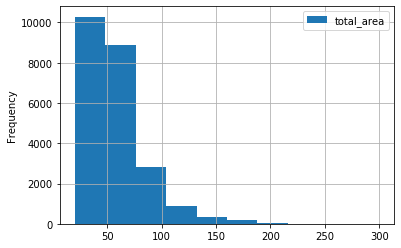

In [31]:
# Отбросим данные с большой и с малой площадью, так как таких строк не так много

good_total_area = df.query('20 < total_area < 200')
good_total_area.plot(y='total_area', kind = 'hist', grid = True, range = (20, 300))

##### Самый распространенная площадь объектов недвижимость более 20 и менее 50 кв.метров

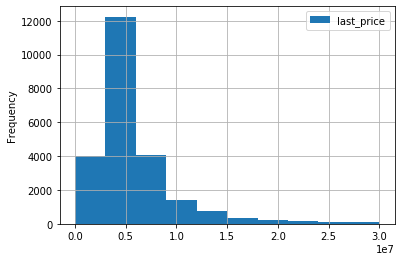

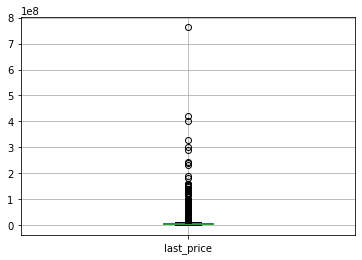

In [32]:
# Гистограмма цены

pd.options.display.float_format = '{:,.1f}'.format # изменяем формат для более удобного вида
df.plot(y='last_price', kind = 'hist', grid = True, range=(0,30000000))
plt.show()
df.boxplot('last_price')
plt.show()

In [33]:
# 707 объектов со слишком завышенной ценой - более 20 млн

too_expensive = len(df.query('last_price > 20000000'))
too_expensive

707

##### Самый распространенная цена объектов недвижимость от 0 до 10 млн

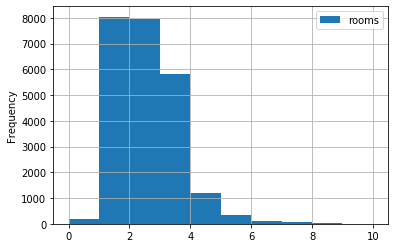

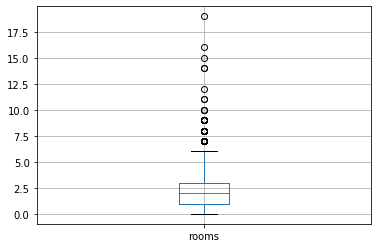

In [34]:
# Гистограмма по количеству комнат

df.plot(y='rooms', kind = 'hist', grid = True, range=(0,10))
plt.show()
df.boxplot('rooms')
plt.show()

In [35]:
# Посмотрим сколько объектов с более 6 комнат

too_big = len(df.query('rooms > 6'))
too_big

# 90 объектов

90

##### Чаще всего стречаются - от 1 до 4 комнатные объекты

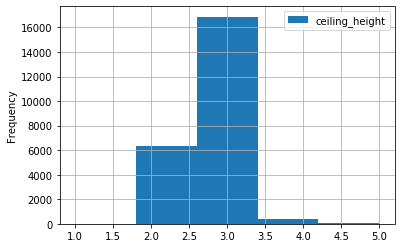

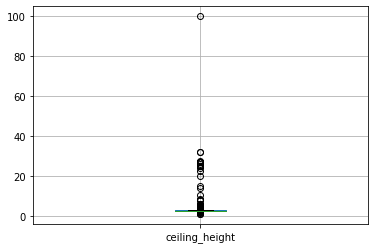

In [36]:
# Гистограмма по высоте потолков

df.plot(y='ceiling_height', kind = 'hist', grid = True, range = (1,5), bins = 5)
plt.show()
df.boxplot('ceiling_height')
plt.show()

In [37]:
# Высота потолков более 5 метров для жилого помещения - скорее всего выброс, посмотрим сколько таких строк

too_high = len(df.query('ceiling_height > 3.5'))
too_high

305

##### Стандартная высота потолков - 2,77

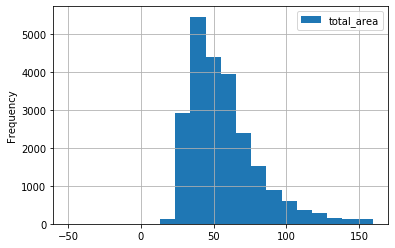

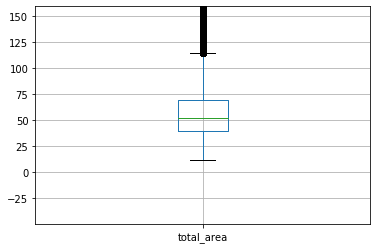

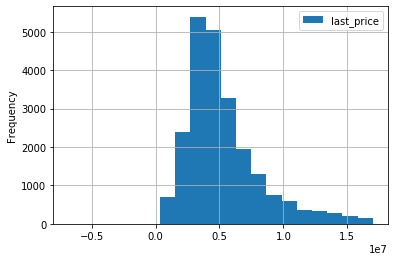

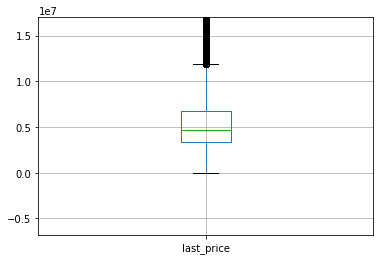

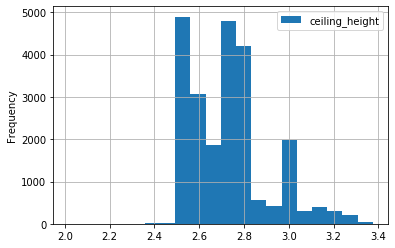

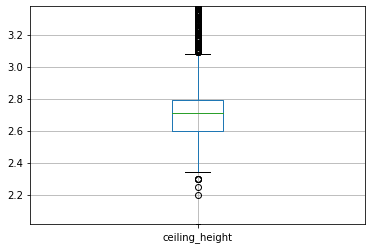

In [38]:
# Добавим цикл для построения всех графиков

current_dimensions_list = ['total_area', 'last_price', 'ceiling_height']
for dimension in current_dimensions_list:
    # посчитаем Q1 и Q3
    perc75 = np.percentile(df[dimension], 75)
    perc25 = np.percentile(df[dimension], 25)
    IQR = perc75 - perc25 # рассчитаем квантильный размах
    _min = perc25 - 3*IQR # минимальная граница оси
    _max = perc75 + 3*IQR # максимальная граница оси
    df.plot(y = dimension, kind = 'hist', grid = True, bins = 20, range = (_min, _max))
    plt.show()
    df.boxplot(dimension)
    plt.ylim(_min, _max)
    plt.show()

#### Изучим время от момента публикации до продажи квартиры

<function matplotlib.pyplot.show(*args, **kw)>

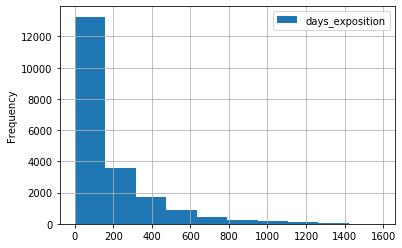

In [40]:
df.plot(y='days_exposition', kind = 'hist', grid = True)
plt.show

In [41]:
too_long = df.query('days_exposition > 600')
len(too_long) # сколько таких значений

1198

In [42]:
 # Помним про NaN, которые сооветствуют непроданным объектам
 # Создим столбец с со статусом "Is sold"

df.loc[df['days_exposition'].isna(),'is_sold'] = False
df.loc[df['days_exposition'].notna(),'is_sold'] = True  

In [43]:
# Сохраним валидные значения по проданной недвижимости

sold_good_estate = df.query('is_sold == True and days_exposition<600')

# Посмотрим среднее

sold_good_estate['days_exposition'].mean()

139.08433859694537

In [44]:
# Посмотрим медиану

sold_good_estate['days_exposition'].median()

89.00000000000001

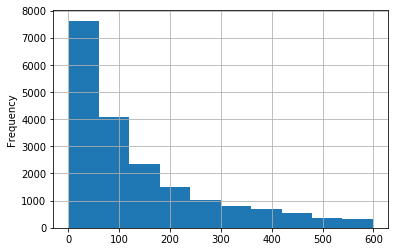

In [45]:
# Nan или их отсутствие не меняет существенно график

sold_good_estate['days_exposition'].plot(y='days_exposition', kind = 'hist', grid = True)

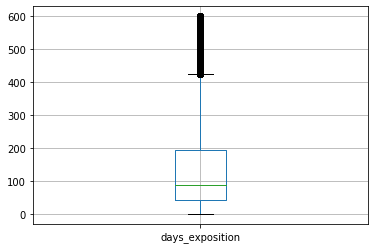

In [46]:
#  Диаграмма рахмаха тоже показывает, что выбросы начинаются от 500 дня, оставим данные до 600 дня

sold_good_estate.boxplot('days_exposition')

#### Средний срок продажи квартиры - 139 дней, большинство объектов недвижимости продается в течение 1 года, с момента подачи объявления. Медианное значение - 89 дней. Таким образом, слишком долгий срок продажи - более 1 года, слишком быстрый менее 3х месяцев.

In [47]:
# Cоздаем датасет без редких значений для проданной недвижимости
# На прошлых этапах были определены критерии для выборки

good_sold_df = df.query('20 < total_area < 200 and '
                   'last_price < 20000000 and '
                   'rooms < 6 and '
                   'ceiling_height < 3.5 and '
                   'is_sold == True and '
                   'days_exposition < 600')
len(good_sold_df)

18540

#### Что убрали:
    1. Слишком маленькую (менее 20) и слишком большую площадь (более 300 кв.м)  
    2. Оставили объекты со стоимостью менее 20 млн.
    3. Количество комнат менее 6
    4. Высота потолков менее 3,5 метров

#### Зависит ли цена от кв.метра от числа комнат, удалённости от центра, на каком этаже расположена квартира, есть ли зависимость от даты размещения: дня недели, месяца и года

0.7624652410618673
0.48445394196412395


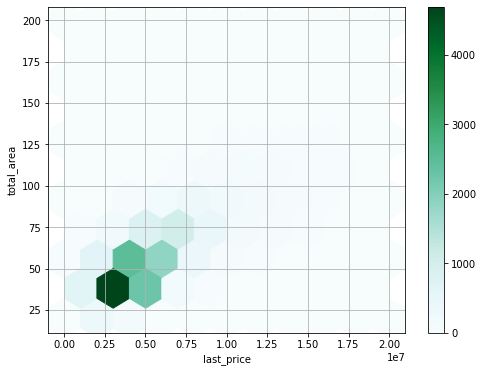

0.6389178374342539


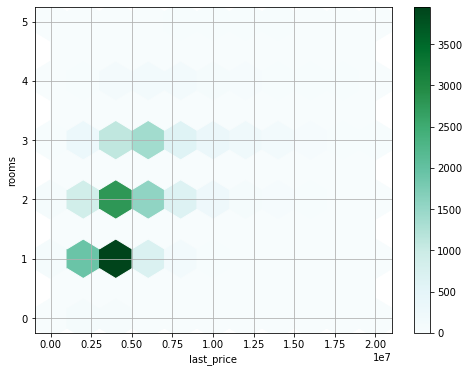

-0.28451065798745


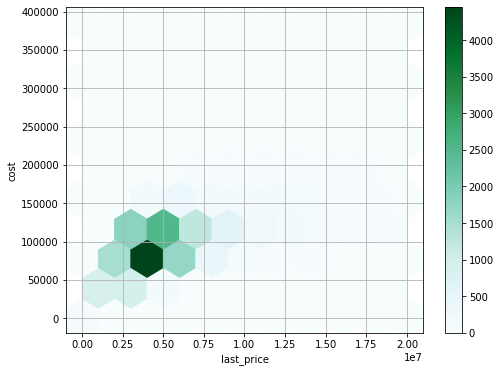

-0.006405729706181937


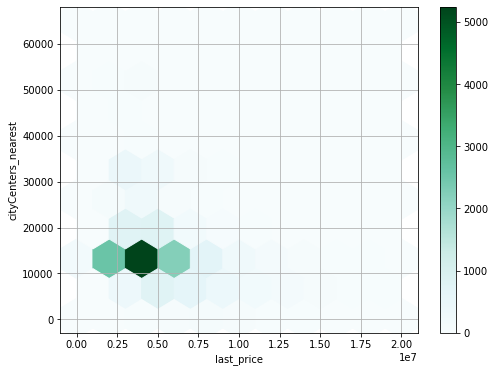

0.0069607232375026706


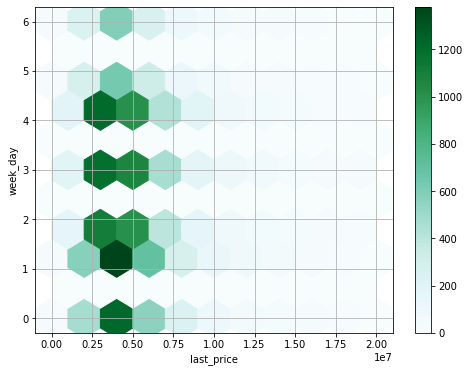

-0.023545803354907056


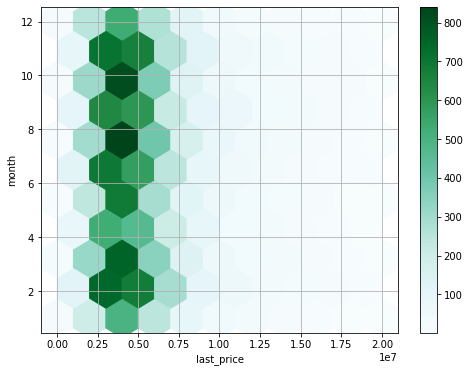

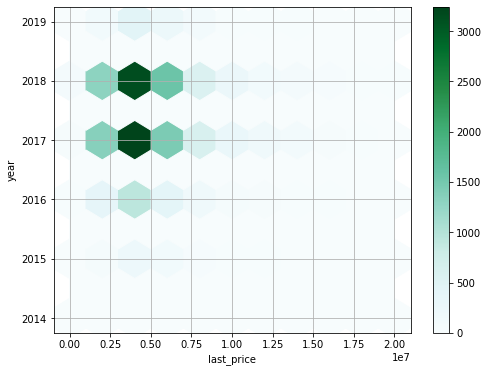

In [48]:
corr_list = ['total_area', 'rooms', 'cost', 'cityCenters_nearest', 'week_day', 'month', 'year'] # список количественных признаков
for corr in corr_list:
    print(good_sold_df['last_price'].corr(good_sold_df[corr]))
    plt.show()
    
    # Данный тип диаграммы "тяжелый", но наглядно показывает распространненость признаков
    
    good_sold_df.plot(x='last_price', y = corr, kind='hexbin', gridsize=10, figsize=(8, 6), sharex=False, grid=True)

#### Несмотря на то, что сильной корреляции стоимости с датой публикации нет, можно отметить, что больше всего в базе недвидимости однокомнатных квартир,  что чаще всего объявления с большей ценой публикуют во вторник, в графике с месяцами можно заметить, что больше всего стоимость объектов в августе и октябре.

In [49]:
#  Создадим DataFrame с рассматриваемыми величинами для построения матрицы корреляции
# На прошлом шаге уже смотрели корреляцию, по признакам, но матрица коррелции более наглядна

corr_df = good_sold_df[[
    'last_price','total_area', 'rooms', 'cityCenters_nearest', 'week_day', 'month', 'year']]
corr_df.corr()

#  Обращаем внимание, что first_last_floor и day_of_week остались не проанализированными

,last_price,total_area,rooms,cityCenters_nearest,week_day,month,year
last_price,1.0,0.8,0.5,-0.3,-0.0,0.0,-0.0
total_area,0.8,1.0,0.8,-0.2,-0.0,0.0,-0.1
rooms,0.5,0.8,1.0,-0.1,-0.0,0.0,-0.1
cityCenters_nearest,-0.3,-0.2,-0.1,1.0,0.0,-0.0,0.0
week_day,-0.0,-0.0,-0.0,0.0,1.0,0.0,-0.0
month,0.0,0.0,0.0,-0.0,0.0,1.0,-0.2
year,-0.0,-0.1,-0.1,0.0,-0.0,-0.2,1.0


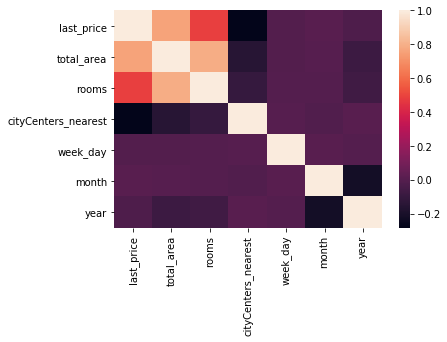

In [50]:
sns.heatmap(corr_df.corr()) # построим тепловую карту

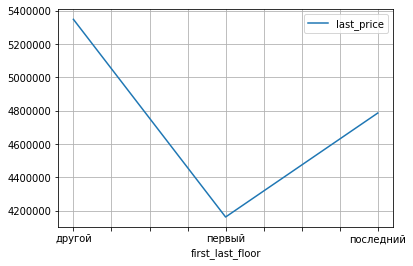

In [51]:
# Проанализируем категориальные признаки first_last_floor и day_of_week через сводные таблицы

first_last_floor_price = good_sold_df.pivot_table(index = 'first_last_floor', values = 'last_price', aggfunc = 'mean')
first_last_floor_price.plot(grid = True)

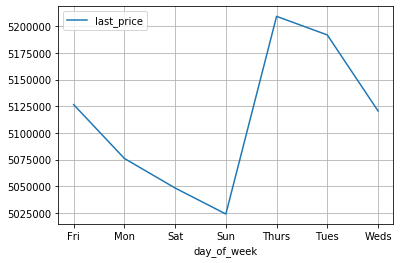

In [52]:
# построим сводную таблицу для наглядности зависимости дня недели и цены

day_of_week_price = good_sold_df.pivot_table(index = 'day_of_week', values = 'last_price', aggfunc = 'mean')
day_of_week_price.sort_values(by=['day_of_week']).plot(grid = True)

#### Самый высокий показатель корреляции среди количественных признаков это корреляция last_price с total_area (0,8), средний показатель -  цена за квадратный метр и количество комна (0,5). Сила связи с другими переменными очень слабая (около 0) -  не будем брать их в расчет.
#### Также есть взаимосвязь площади и количества комнат, что логично
#### Качественный показатель first_last_floor, показывает, что средняя цена проданных квартир на первых этажах меньше, чем на последнем и других. Разница между последним и другими не существенна.

#### Проанализируем топ-10 населенных пунктов по стоимости жилья

In [53]:
locality_grouped = good_sold_df.groupby(
    'locality_name')['last_price'].count().sort_values(ascending = False).head(10)  

top_index_list = pd.Series(locality_grouped).index  # список индексов
top_list = top_index_list.tolist()  # список городов

# создаем срез c наибольшим количеством объявлений
good_sold_df_top =  good_sold_df.query('locality_name in @top_list') 

In [54]:
# Посчитаем среднюю цену квадратного метра

good_sold_df_top['cost'].mean()

101735.1416665106

In [55]:
#  Посчитаем среднюю стоимость квадратного метра во всех городах

good_sold_df['cost'].mean()

# Средняя стоимость квадратного метра - 101 735 в топ-городах выше, чем во всем DataFrame
# С первоначальными данными общее среднее отличается на 6 тысяч

93663.63088338911

In [56]:
#  Построим сводную таблицу для определения минимального и максимальных городов по стоимости жилья

last_price_top_pivot = good_sold_df_top.pivot_table(
    index = 'locality_name', values = 'last_price').sort_values(by='last_price')

last_price_top_pivot

# Топ-1 по средней стоимости жилья ожидаемо - Питер, самое дешевое жилье среди топов - Выборг

,last_price
locality_name,
Выборг,"2,980,068.1"
Гатчина,"3,380,016.3"
Всеволожск,"3,630,924.9"
посёлок Мурино,"3,643,403.0"
Колпино,"3,792,903.5"
посёлок Шушары,"4,054,925.5"
деревня Кудрово,"4,264,649.9"
посёлок Парголово,"4,392,823.5"
Пушкин,"5,590,365.0"


#### Таким образом цена квадратного метра в топ-10 больше, чем во всей выборке. 

#### Посмотрим взаимосвязи недвижимости в центре и средней стоимостью жилья для Питера - как влияет удаленность от центра на стоимость

In [57]:
# создаем столбец с расстоянием в километрах от центра

good_sold_df.loc[:,'cityCenters_nearest_km']  = (good_sold_df['cityCenters_nearest']/1000).round().astype(int)

/Users/snakerka/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/snakerka/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
SPB_good_sold_df = good_sold_df.query('locality_name == "Санкт-Петербург"') #  Срез данных по Питеру
pd.set_option('display.max_columns', None) # для отображения всех столбцов
SPB_good_sold_df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost,week_day,month,year,living_rate,kitchen_rate,cityCenters_nearest_km
count,"12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0","12,127.0"
mean,9.9,"6,037,978.3",56.7,2.0,2.7,11.8,32.4,6.4,10.2,0.6,"28,253.2","12,186.7",0.6,496.1,0.7,527.4,136.0,"106,646.7",2.6,6.6,"2,017.3",0.6,0.2,12.2
std,5.6,"2,957,251.9",22.9,0.9,0.2,6.4,15.4,5.0,4.4,1.0,"11,913.0","4,560.7",0.7,228.4,0.9,194.0,135.9,"26,100.1",1.8,3.4,0.9,0.1,0.1,4.6
min,0.0,"12,190.0",20.1,0.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,287.0,0.0,1.0,0.0,13.0,1.0,111.8,0.0,1.0,"2,014.0",0.0,0.0,0.0
25%,6.0,"4,000,000.0",40.1,1.0,2.6,6.0,18.6,3.0,7.2,0.0,"17,847.0","9,626.0",0.0,490.8,0.0,518.0,38.0,"89,456.9",1.0,3.0,"2,017.0",0.5,0.1,10.0
50%,10.0,"5,100,000.0",51.0,2.0,2.7,10.0,30.0,5.0,10.0,0.0,"27,583.0","12,665.0",0.0,490.8,0.0,518.0,86.0,"102,061.9",3.0,7.0,"2,017.0",0.6,0.2,13.0
75%,14.0,"7,000,000.0",67.8,3.0,2.8,16.0,41.4,9.0,11.3,1.0,"36,978.0","15,114.5",1.0,490.8,1.0,518.0,188.5,"118,644.1",4.0,10.0,"2,018.0",0.6,0.2,15.0
max,50.0,"19,999,000.0",199.2,5.0,3.5,37.0,142.0,33.0,60.0,5.0,"60,195.0","41,294.0",3.0,"3,190.0",3.0,"1,337.0",599.0,"387,096.8",6.0,12.0,"2,019.0",1.5,0.8,41.0


In [59]:
SPB_good_sold_df_grouped = SPB_good_sold_df.sort_values(by='cityCenters_nearest_km')
SPB_good_sold_df_grouped.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost,week_day,day_of_week,month,year,first_last_floor,living_rate,kitchen_rate,is_sold,cityCenters_nearest_km
22036,3,7200000,72.0,2017-12-21,2,3.1,3,44.9,2,False,False,False,12.3,0,Санкт-Петербург,"21,875.0",329.0,3,426.0,3,273.0,89.0,"100,000.0",3,Thurs,12,2017,другой,0.6,0.2,True,0
9488,3,8000000,106.0,2018-07-26,3,3.4,4,47.4,1,False,False,False,10.6,0,Санкт-Петербург,"21,653.0",410.0,3,591.0,2,38.0,60.0,"75,471.7",3,Thurs,7,2018,первый,0.4,0.1,True,0
2988,2,5300000,49.0,2016-11-09,3,3.0,3,30.0,3,False,False,False,7.0,0,Санкт-Петербург,"21,919.0",467.0,2,256.0,3,305.0,232.0,"108,163.3",2,Weds,11,2016,последний,0.6,0.1,True,0
8239,10,13500000,96.9,2018-08-06,3,3.2,7,67.3,3,False,False,False,14.8,0,Санкт-Петербург,"21,982.0",387.0,3,138.0,2,657.0,14.0,"139,318.9",0,Mon,8,2018,другой,0.7,0.2,True,0
2609,20,7200000,80.0,2017-08-24,3,2.8,4,43.0,1,False,False,False,8.0,0,Санкт-Петербург,"21,832.0",399.0,3,415.0,2,516.0,11.0,"90,000.0",3,Thurs,8,2017,первый,0.5,0.1,True,0


In [60]:
# Посмотрим средние значения цены для каждого километра в Питере

SPB_mean_price_pivot = SPB_good_sold_df.pivot_table(
    index = 'cityCenters_nearest_km', values = 'last_price', aggfunc = ['mean', 'count']
)
SPB_mean_price_pivot

,mean,count
,last_price,last_price
cityCenters_nearest_km,,
0,"8,241,428.6",7
1,"9,935,134.8",89
2,"9,079,150.7",146
3,"8,238,794.6",205
4,"8,732,774.0",411
5,"8,838,675.1",533
6,"8,089,594.5",391
7,"7,660,507.0",270


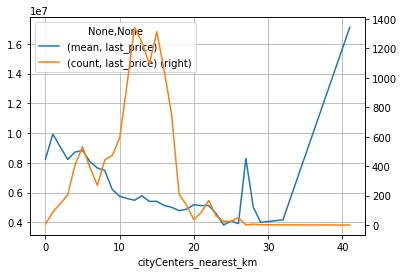

In [61]:
# Построим график, как меняется средняя стоимость квартиры от отдаленности

SPB_mean_price_pivot[('mean', 'last_price')].plot(grid=True, style = '-', legend = True)
SPB_mean_price_pivot[('count', 'last_price')].plot(secondary_y=True, grid=True, style = '-',  legend = True)

####  Самый большой спад был при переходе от 7 до 8 км

####  Следовательно, можно сделать вывод, что  центральный район считается в диаметре 7 км

In [62]:
SPB_good_sold_df_grouped_city_centre = SPB_good_sold_df_grouped.query(
    'cityCenters_nearest_km <= 7'
) # Срез по центру
SPB_good_sold_df_grouped_city_centre

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost,week_day,day_of_week,month,year,first_last_floor,living_rate,kitchen_rate,is_sold,cityCenters_nearest_km
22036,3,7200000,72.0,2017-12-21,2,3.1,3,44.9,2,False,False,False,12.3,0,Санкт-Петербург,"21,875.0",329.0,3,426.0,3,273.0,89.0,"100,000.0",3,Thurs,12,2017,другой,0.6,0.2,True,0
9488,3,8000000,106.0,2018-07-26,3,3.4,4,47.4,1,False,False,False,10.6,0,Санкт-Петербург,"21,653.0",410.0,3,591.0,2,38.0,60.0,"75,471.7",3,Thurs,7,2018,первый,0.4,0.1,True,0
2988,2,5300000,49.0,2016-11-09,3,3.0,3,30.0,3,False,False,False,7.0,0,Санкт-Петербург,"21,919.0",467.0,2,256.0,3,305.0,232.0,"108,163.3",2,Weds,11,2016,последний,0.6,0.1,True,0
8239,10,13500000,96.9,2018-08-06,3,3.2,7,67.3,3,False,False,False,14.8,0,Санкт-Петербург,"21,982.0",387.0,3,138.0,2,657.0,14.0,"139,318.9",0,Mon,8,2018,другой,0.7,0.2,True,0
2609,20,7200000,80.0,2017-08-24,3,2.8,4,43.0,1,False,False,False,8.0,0,Санкт-Петербург,"21,832.0",399.0,3,415.0,2,516.0,11.0,"90,000.0",3,Thurs,8,2017,первый,0.5,0.1,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20380,17,6800000,66.0,2016-10-13,3,2.8,5,41.0,2,False,False,False,10.6,0,Санкт-Петербург,"15,493.0","7,455.0",0,490.8,0,518.0,173.0,"103,030.3",3,Thurs,10,2016,другой,0.6,0.2,True,7
10790,8,6200000,51.0,2018-03-15,2,2.7,7,30.0,1,False,False,False,9.0,0,Санкт-Петербург,"15,425.0","7,475.0",0,490.8,0,518.0,304.0,"121,568.6",3,Thurs,3,2018,первый,0.6,0.2,True,7
2278,5,11900000,60.8,2017-07-01,1,3.0,9,20.0,3,False,False,False,19.9,2,Санкт-Петербург,"25,490.0","6,597.0",1,543.0,0,518.0,520.0,"195,595.0",5,Sat,7,2017,другой,0.3,0.3,True,7
9968,10,6800000,79.0,2019-01-28,3,3.0,5,56.0,1,False,False,False,8.0,0,Санкт-Петербург,"28,195.0","7,042.0",0,490.8,0,518.0,16.0,"86,075.9",0,Mon,1,2019,первый,0.7,0.1,True,7


In [63]:
#  Посмотрим корреляцию расстояния и цены по всем данным недевижимости Петербурга

SPB_good_sold_df_grouped['last_price'].corr(SPB_good_sold_df_grouped['cityCenters_nearest_km'])

-0.374838056478853

In [64]:
#  Посмотрим корреляцию расстояния и цены по недвижимости в центре

SPB_good_sold_df_grouped_city_centre['last_price'].corr(SPB_good_sold_df_grouped_city_centre['cityCenters_nearest_km'])

-0.11458170937443464

##### Корреляция между отдаленностью от центра и средней стоимостью квартиры по всем данным очень слабая, взаимосвязи практически нет. В центре дорогие квартиры из-за местоположения, в отдаленные районах можно сделать предположение, что там лучше условия проживания и дома более новые
#####  В центре корреляция от отдаленностью и средней стоимостью квартиры 10%. 

#### Рассмотрим подробнее сегмент недвижимости по центральному району

In [65]:
SPB_good_sold_df_grouped_city_centre.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost,week_day,month,year,living_rate,kitchen_rate,cityCenters_nearest_km
count,"2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0","2,052.0"
mean,9.6,"8,522,406.5",72.0,2.4,2.9,7.3,41.9,4.2,12.0,0.3,"24,497.0","4,683.8",0.9,482.7,1.3,495.4,164.2,"122,433.7",2.6,6.7,"2,017.2",0.6,0.2,4.6
std,5.7,"3,530,844.1",28.1,1.0,0.2,4.1,19.8,3.0,5.3,0.8,"4,159.7","1,601.1",0.9,258.6,1.1,227.2,147.8,"36,400.9",1.7,3.4,0.9,0.1,0.1,1.6
min,0.0,"1,600,000.0",20.3,0.0,2.4,2.0,2.0,1.0,2.0,0.0,"12,430.0",287.0,0.0,9.0,0.0,22.0,3.0,"15,345.3",0.0,1.0,"2,014.0",0.0,0.1,0.0
25%,5.0,"5,950,000.0",50.0,2.0,2.8,5.0,28.0,2.0,8.6,0.0,"21,518.2","3,704.0",0.0,377.0,0.0,361.2,53.0,"97,306.0",1.0,4.0,"2,017.0",0.5,0.1,4.0
50%,9.0,"7,700,000.0",68.3,2.0,2.9,6.0,39.0,3.0,10.6,0.0,"24,188.0","4,819.5",1.0,490.8,1.0,518.0,110.0,"115,765.1",3.0,7.0,"2,017.0",0.6,0.2,5.0
75%,14.0,"10,500,000.0",87.9,3.0,3.0,9.0,53.0,5.0,14.0,0.0,"27,262.2","5,881.0",1.0,498.0,2.0,592.0,244.2,"140,713.4",4.0,10.0,"2,018.0",0.7,0.2,6.0
max,35.0,"19,999,000.0",197.0,5.0,3.5,25.0,142.0,23.0,50.2,5.0,"39,763.0","7,498.0",3.0,"2,295.0",3.0,"1,251.0",599.0,"387,096.8",6.0,12.0,"2,019.0",1.1,0.6,7.0


In [66]:
#  список признаков, для расчета корреляции между количественными признаками

corr_df_2 = SPB_good_sold_df_grouped_city_centre[[
    'total_area', 'last_price', 'cost', 'rooms', 'ceiling_height']]
corr_df_2.corr()

,total_area,last_price,cost,rooms,ceiling_height
total_area,1.0,0.7,-0.3,0.8,0.2
last_price,0.7,1.0,0.4,0.4,0.1
cost,-0.3,0.4,1.0,-0.4,-0.1
rooms,0.8,0.4,-0.4,1.0,0.3
ceiling_height,0.2,0.1,-0.1,0.3,1.0


#### Самый высокий показатель корреляции среди количественных признаков это корреляция с total_area (0,8), средний показатель - rooms (0,7) - что совпадает с общей базой недвижимости. Также есть сильная взаимосвязь, общей площади и стоимости, интересно, что связь количества комнат и стоимости - средняя, как и в общей базе.

In [67]:
# список признаков для расчета корреляции со значениями last_price и cost
corr_df_3 = SPB_good_sold_df_grouped_city_centre[[
    'last_price', 'cost', 'floor', 'cityCenters_nearest']]
corr_df_3.corr()

,last_price,cost,floor,cityCenters_nearest
last_price,1.0,0.4,0.2,-0.1
cost,0.4,1.0,0.2,0.1
floor,0.2,0.2,1.0,0.3
cityCenters_nearest,-0.1,0.1,0.3,1.0


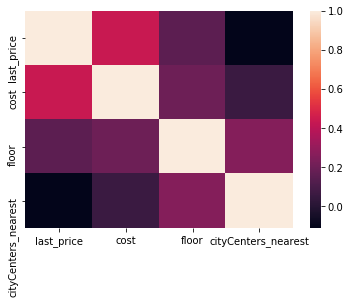

In [68]:
# построим тепловую карту
sns.heatmap(corr_df_3.corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ff9d990>,
      dtype=object)

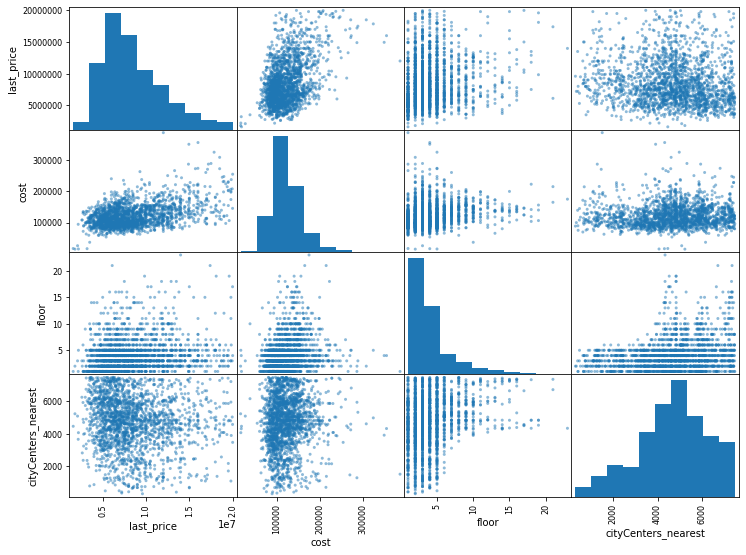

In [69]:
# построим матрицу графиков от количественных признаков
pd.plotting.scatter_matrix(corr_df_3, figsize = (12,9))

**Есть слабая корреляция между ценой и стоимостью квадратного метра. Влиянение других параметров на стоимость квадратного метра в центре города не существенно**


#### Интересно, что на цену недвижимости в центре не коррелирует с близостью к центру и этажности. Скорее всего это связано с тем, что  центре объекты недвижимости маловысотные и все являются центром :)
#### Посмотрим зависимость цены и дату публикацию объявлений

In [70]:
corr_df_date = SPB_good_sold_df_grouped_city_centre[[
    'last_price','cost','week_day', 'month', 'year']]
corr_df_date.corr()

,last_price,cost,week_day,month,year
last_price,1.0,0.4,0.0,-0.0,-0.0
cost,0.4,1.0,0.0,-0.0,0.1
week_day,0.0,0.0,1.0,0.0,0.0
month,-0.0,-0.0,0.0,1.0,-0.2
year,-0.0,0.1,0.0,-0.2,1.0


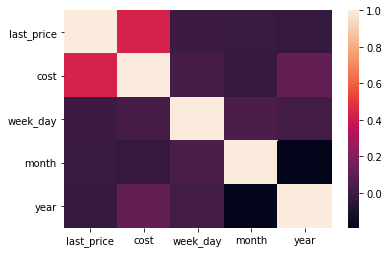

In [71]:
# построим тепловую карту
sns.heatmap(corr_df_date.corr())

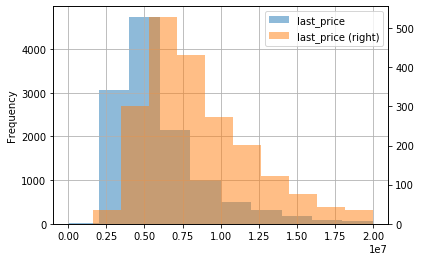

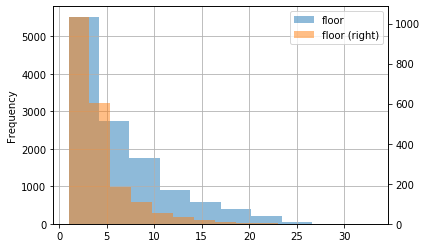

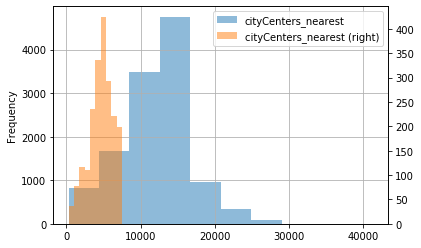

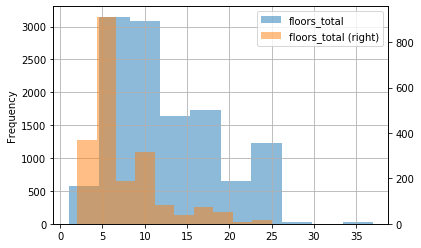

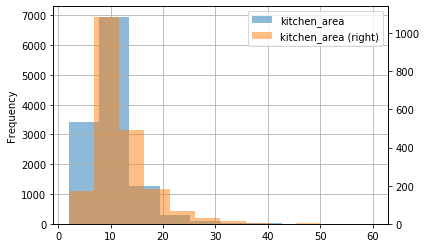

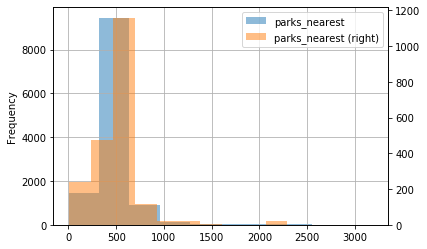

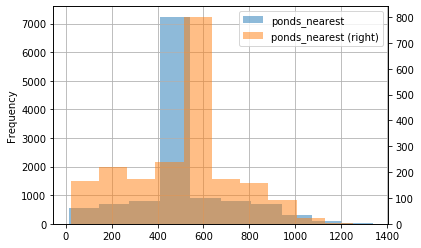

In [72]:
# построим зависимость цены квадратного метра от цены, этажа, этажности, отдаленности от центра, наличие прудов и парков
# и как влияет зависимость этих показателей на объектах в центре и в остальной части
# список признаков
list_dimensions =[
    'last_price', 'floor', 'cityCenters_nearest', 'floors_total', 'kitchen_area', 'parks_nearest', 'ponds_nearest']

# цикл, который показывает создает 
for dim in list_dimensions:
    SPB_good_sold_df_grouped[dim].plot(
        x = 'cost', y = dim, kind = 'hist', grid=True, style = 'o', legend = True, alpha = 0.5
    )  # график для всего СПб
    
    SPB_good_sold_df_grouped_city_centre[dim].plot(
        x = 'cost', y = dim, secondary_y=True, kind = 'hist', grid=True, style = 'o',  legend = True, alpha = 0.5
    ) #  график для центра города
    plt.show()

#### Дата публикации не взаимосвязана со стоимостью жилья

### Шаг 5. Общий вывод

#### По данным анализа можно сделать следующие выводы:
    1. На стоимость объектов больше всего влияет общая площадь объекта, следующим важным признаком влияющим на стоимость объектов - количество комнат. Данные показатели корреляции сохраняются, как в общей базе недвижимости, так и в центральном районе. Следовательно, можно сделать вывод, что тенденция ценообразования на рынке недвижимости Питера схожа для всех районов. Цена квадратного метра влияет на стоимость в общей выборке, в центре взаимосвязь этих признаков более слабая.
    2. Стоимость квадратного метра в топ-10 городах выше, чем в среднем по Питеру и Лен.области, следовательно спрос на недвижимость выше в крупных городах и населенных пунктах близких к Питеру. Но стоит отметить, что разница в цене кв метра менее 10 тысяч рублей. 
    3. Удаленность от центра города, дата публикации объявления, высота потолков, этажность дома и этаж расположения объекта влияют незначительно на стоимость - корреляция очень слабая.
    4. В среднем срок публикации объявления до дня продажи 139 дней (около 4 месяцев) 